In [26]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

def filter_df(df):
    # quick filter to see if the model is working without photons etc.
    df = df[(df.pid == 2112) | ( df.pid == 130 )]
    return df


In [27]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/g/gkrzmanc/2024/eval_1015/debug_eval_FT_Ep_reg_1015/showers_df_evaluation/0_0_None_pandora.pt"
sd_hgb1, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/g/gkrzmanc/2024/eval_1015/debug_eval_FT_Ep_reg_1015/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
sd_hgb.number_batch.unique()

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 5.097e+03, 5.098e+03,
       5.099e+03], dtype=float32)

In [28]:
len(sd_hgb), len(sd_hgb1)

(99590, 95002)

In [95]:
#sd_hgb = filter_df(sd_hgb)
#sd_hgb1 = filter_df(sd_hgb1)

In [5]:
filter_pi = sd_hgb1.pid == -211
masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo[filter_pi].values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos[filter_pi].values.tolist()), axis=1)**2)

/tmp/gkrzmanc/ipykernel_11131/1869114739.py:2: RuntimeWarning: invalid value encountered in sqrt
  masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo[filter_pi].values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos[filter_pi].values.tolist()), axis=1)**2)


In [12]:
filter_pi_1 = sd_hgb.pid ==-211
masses_ML_model = np.sqrt(sd_hgb.calibrated_E[filter_pi_1].values**2 - np.linalg.norm(np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist()), axis=1)**2)

/tmp/gkrzmanc/ipykernel_5686/3362828194.py:2: RuntimeWarning: invalid value encountered in sqrt
  masses_ML_model = np.sqrt(sd_hgb.calibrated_E[filter_pi_1].values**2 - np.linalg.norm(np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist()), axis=1)**2)


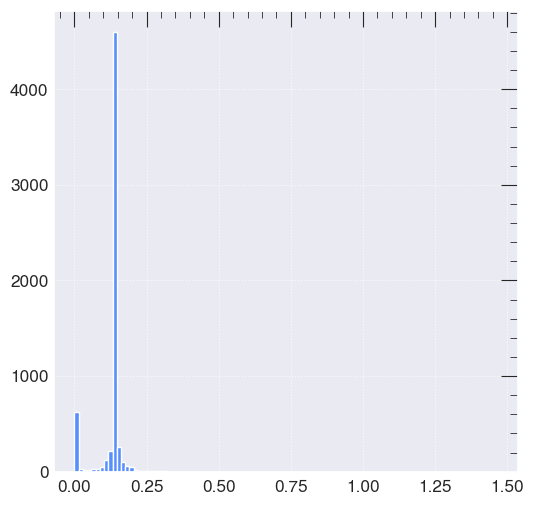

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(masses_pandora, bins=100)
fig.show()

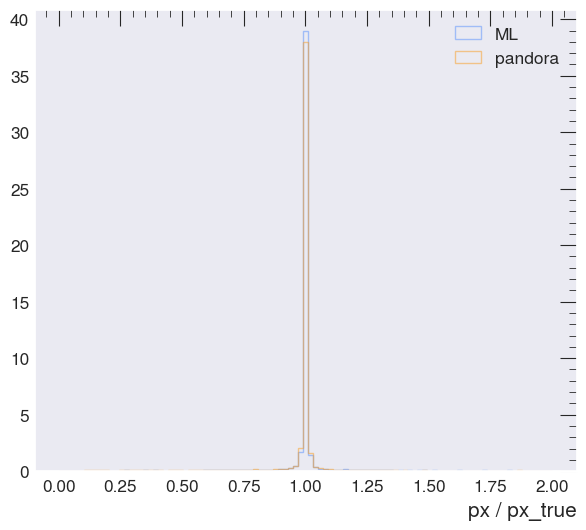

In [14]:
p_ratios = (np.linalg.norm(np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist()), axis=1) /  np.linalg.norm(np.array(sd_hgb.true_pos[filter_pi_1].values.tolist()), axis=1))
px_ratios = (np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist())[:,0] / np.array(sd_hgb.true_pos[filter_pi_1].values.tolist())[:,0])
px_ratios_pandora = (np.array(sd_hgb1.pandora_calibrated_pos[filter_pi].values.tolist())[:,0] / np.array(sd_hgb1.true_pos[filter_pi].values.tolist())[:,0])
pandora_is_track_in_clust = sd_hgb1.is_track_in_cluster[filter_pi].values.astype(bool)
is_track_in_cluster = sd_hgb.is_track_in_cluster[filter_pi_1].values.astype(bool)

# histogram
fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0, 2, 100)
ax.hist(px_ratios, bins=bins, label="ML", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios_pandora, bins=bins, label="pandora", alpha=0.5, histtype="step", density=True)
ax.legend()
ax.grid()
ax.set_xlabel("px / px_true")
fig.show()


In [15]:
print("Pandora:")
print(pd.Series(pandora_is_track_in_clust).value_counts(normalize=True))
print("ML:")
print(pd.Series(is_track_in_cluster).value_counts(normalize=True))

Pandora:
True     0.726917
False    0.273083
dtype: float64
ML:
True     0.756307
False    0.243693
dtype: float64


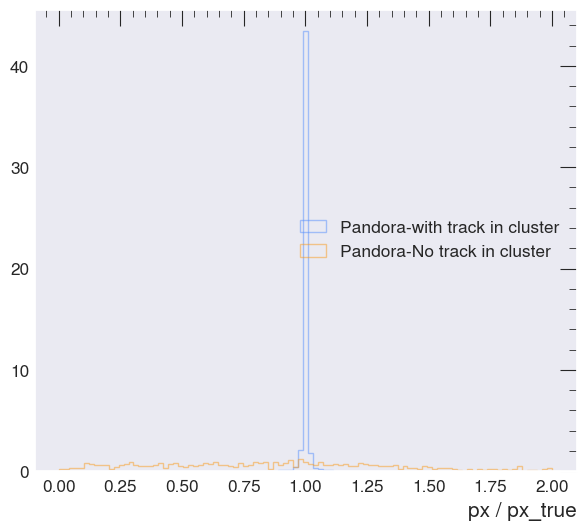

In [16]:

fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0 ,2, 100)
#ax.hist(px_ratios[is_track_in_cluster], bins=bins, label="ML-with track in cluster", alpha=0.5, density=True, histtype="step")
#ax.hist(px_ratios[~is_track_in_cluster],  bins=bins, label="ML-no track in cluster", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios_pandora[pandora_is_track_in_clust],bins=bins, label="Pandora-with track in cluster", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios_pandora[~pandora_is_track_in_clust],bins=bins, label="Pandora-No track in cluster", alpha=0.5, density=True, histtype="step")

ax.legend()
ax.grid()
ax.set_xlabel("px / px_true")

fig.show()


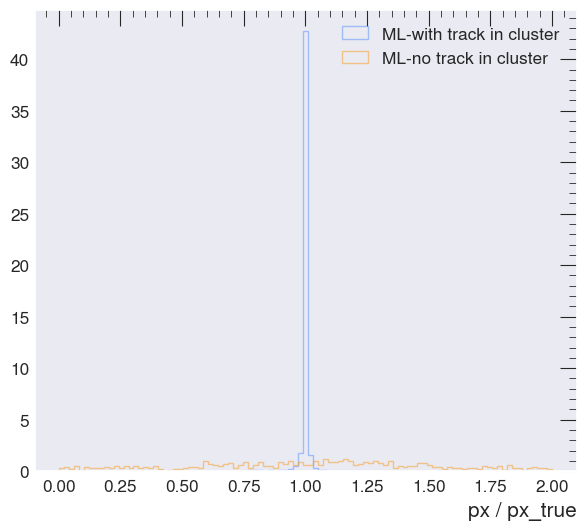

In [17]:

fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0, 2, 100)
ax.hist(px_ratios[is_track_in_cluster], bins=bins, label="ML-with track in cluster", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios[~is_track_in_cluster],  bins=bins, label="ML-no track in cluster", alpha=0.5, density=True, histtype="step")

ax.legend()
ax.grid()
ax.set_xlabel("px / px_true")
fig.show()


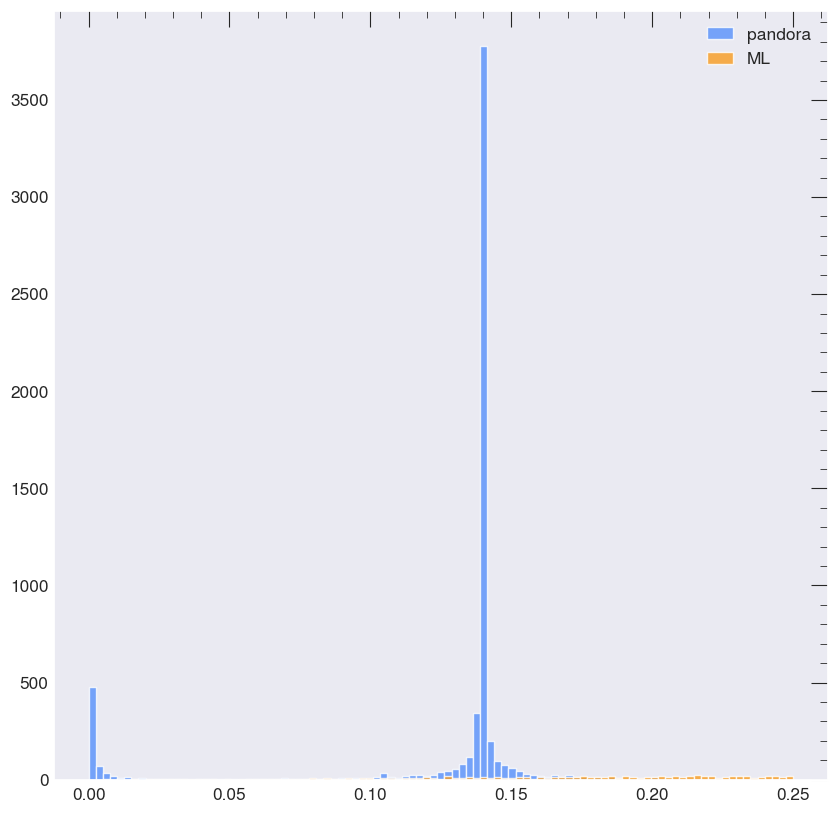

In [18]:
fig, ax = plt.subplots()
bins = np.linspace(0, 0.25, 100)
ax.hist(masses_pandora, bins=bins, label="pandora", alpha=0.8)
ax.hist(masses_ML_model, bins=bins, label="ML", alpha=0.8)
misidentified_pi_pandora = masses_pandora < 0.1
ax.legend()
ax.grid()
fig.show()

In [19]:
# print percentages of misID pi
print(np.sum(misidentified_pi_pandora) / len(misidentified_pi_pandora))

0.09649344096871847


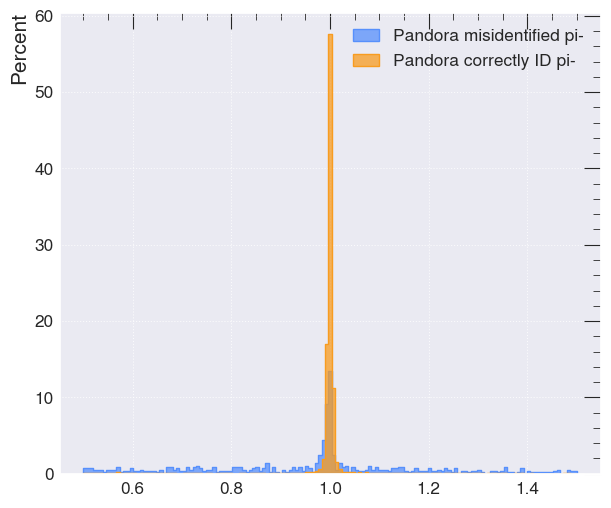

In [20]:
# Pandora filter
import seaborn as sns
bins=np.linspace(0.5, 1.5, 150)
#plt.figure() # create a bit smaller fig
plt.figure(figsize=(7, 6))
pions_pandora = (sd_hgb1[(sd_hgb1.pid==-211)].pandora_calibrated_pfo.values)/(sd_hgb1[(sd_hgb1.pid==-211)].true_showers_E.values)
sns.histplot(pions_pandora[misidentified_pi_pandora], stat="percent", label="Pandora misidentified pi-", element="step", bins=bins)
sns.histplot(pions_pandora[~misidentified_pi_pandora], stat="percent",  label="Pandora correctly ID pi-", element="step", bins=bins)
plt.legend()


(7903,) (7903,)


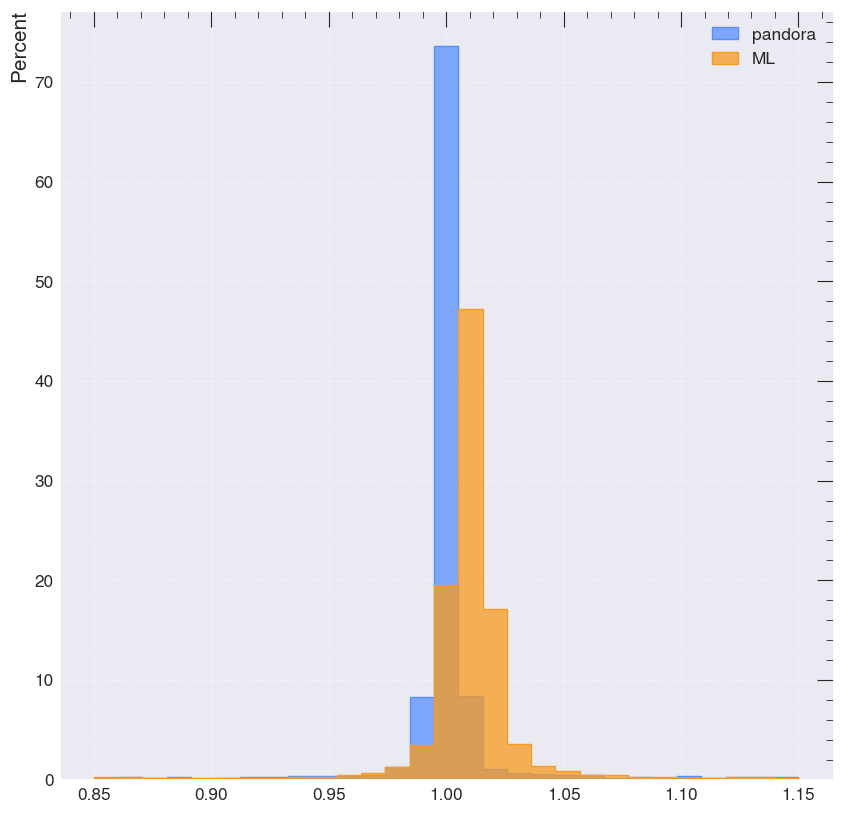

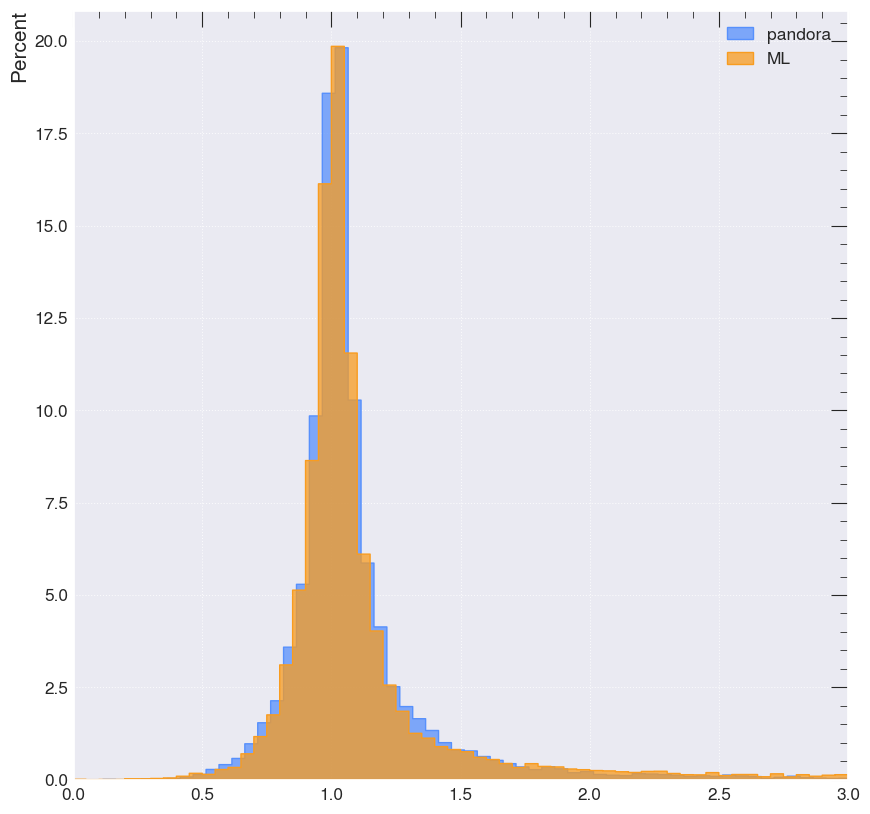

In [21]:
import seaborn as sns
bins=np.linspace(0.85, 1.15, 30)
plt.figure()
pions_pandora = (sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values)
pions_ml = (sd_hgb[sd_hgb.pid==211].calibrated_E.values)/(sd_hgb[sd_hgb.pid==211].true_showers_E.values)
print(pions_pandora.shape, pions_ml.shape)
sns.histplot(pions_pandora, stat="percent", bins=bins, label="pandora", element="step")
sns.histplot(pions_ml, stat="percent", bins=bins, label="ML", element="step")
#sns.histplot((sd_hgb2[sd_hgb2.pid==211].calibrated_E.values)/(sd_hgb2[sd_hgb2.pid==211].true_showers_E.values), stat="percent", bins=bins, label="ML #new", color="green")
#plt.xlim([0, 2])

plt.legend()


import seaborn as sns
plt.figure()
photons_pandora = (sd_hgb1[sd_hgb1.pid==22].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==22].true_showers_E.values)
photons_ml = (sd_hgb[sd_hgb.pid==22].calibrated_E.values)/(sd_hgb[sd_hgb.pid==22].true_showers_E.values)
sns.histplot((sd_hgb1[sd_hgb1.pid==22].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==22].true_showers_E.values), stat="percent", binwidth=0.05, label="pandora", element="step")
sns.histplot((sd_hgb[sd_hgb.pid==22].calibrated_E.values)/(sd_hgb[sd_hgb.pid==22].true_showers_E.values), stat="percent", binwidth=0.05, label="ML", element="step")
plt.xlim([0, 3])
plt.legend()
#path_hgcal = "/eos/user/g/gkrzmanc/eval_plots_EC/eval_Ks_EC_GT_model_on_pis_Ks_dataset/showers_df_evaluation/0_0_None_pandora.pt


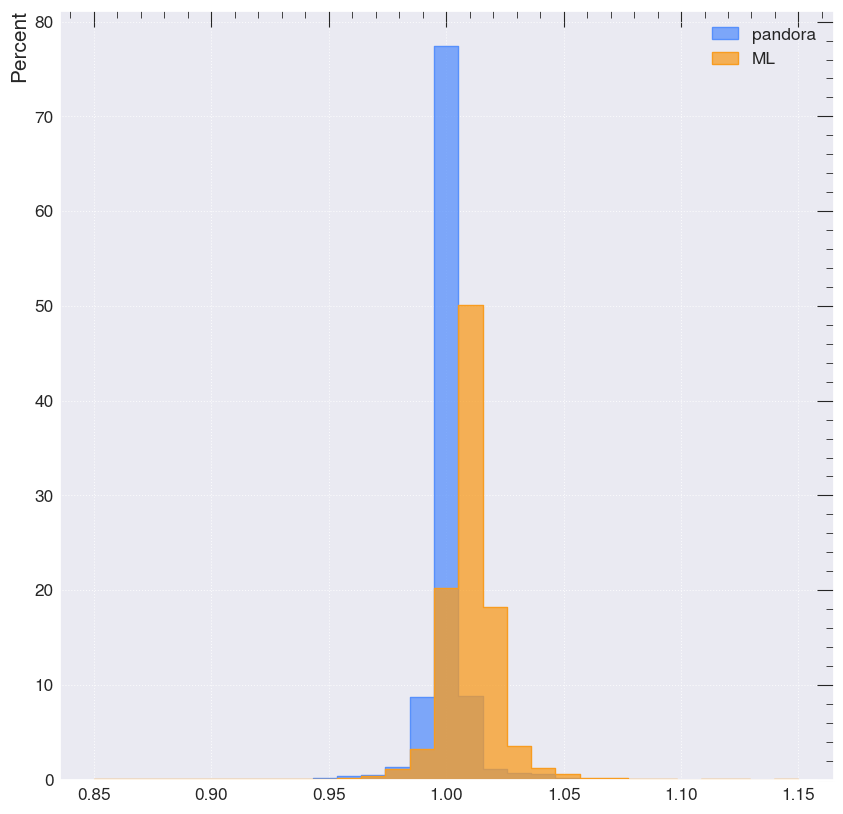

In [22]:
# This doesn't work right ? ?
import seaborn as sns
bins=np.linspace(0.85, 1.15, 30)
plt.figure()
pandora_good = np.abs(pions_pandora - 1) < 0.05
pandora_bad = np.abs(pions_pandora - 1) >= 0.05
sns.histplot(pions_pandora[pandora_good], stat="percent", bins=bins, label="pandora", element="step")
sns.histplot(pions_ml[pandora_good], stat="percent", bins=bins, label="ML", element="step")
#sns.histplot((sd_hgb2[sd_hgb2.pid==211].calibrated_E.values)/(sd_hgb2[sd_hgb2.pid==211].true_showers_E.values), stat="percent", bins=bins, label="ML #new", color="green")
#plt.xlim([0, 2])
plt.legend()

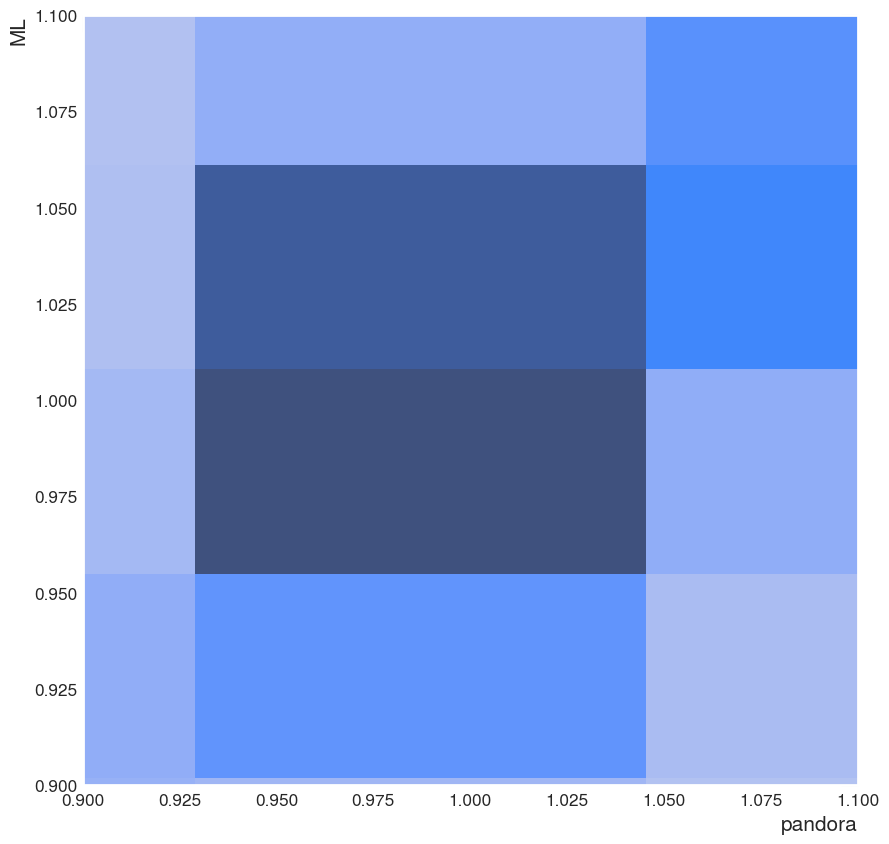

In [23]:
# same with photons
sns.histplot(x=photons_pandora, y=photons_ml, bins=800)
plt.xlim([0.9, 1.1])
plt.ylim([0.9, 1.1])
plt.xlabel("pandora")
plt.ylabel("ML")
plt.show()

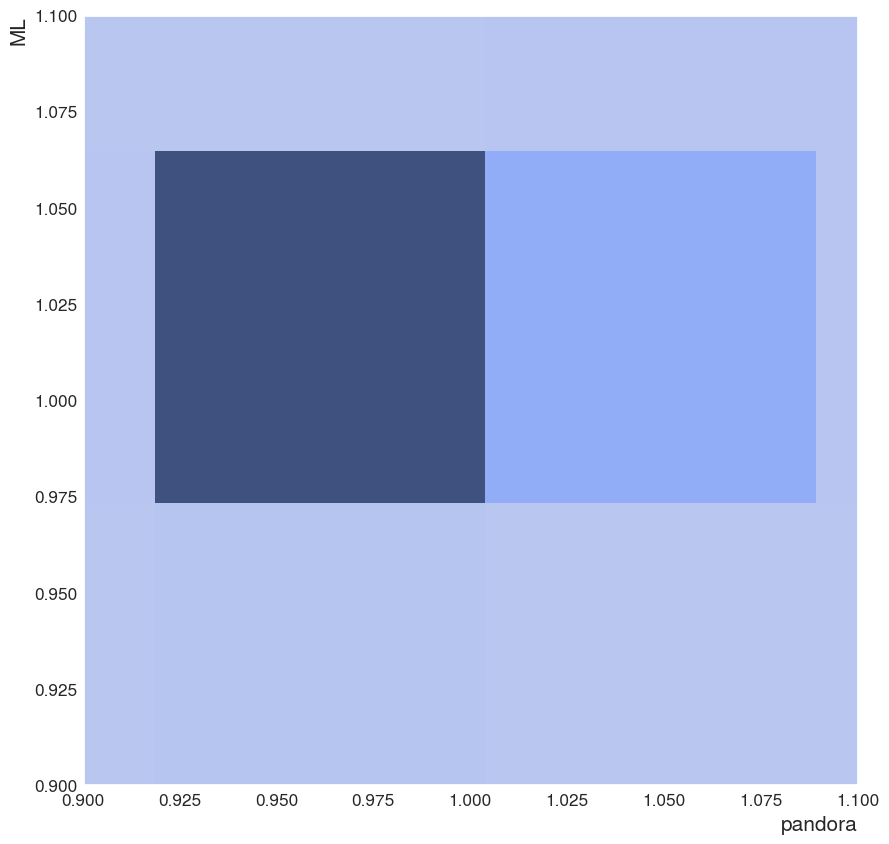

In [24]:
# plot a 2d hist

sns.histplot(x=pions_pandora, y=pions_ml, bins=500)
plt.xlim([0.9, 1.1])
plt.ylim([0.9, 1.1])
plt.xlabel("pandora")
plt.ylabel("ML")
plt.show()

/tmp/gkrzmanc/ipykernel_5686/91781637.py:2: RuntimeWarning: invalid value encountered in sqrt
  masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo.values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos.values.tolist()), axis=1)**2)


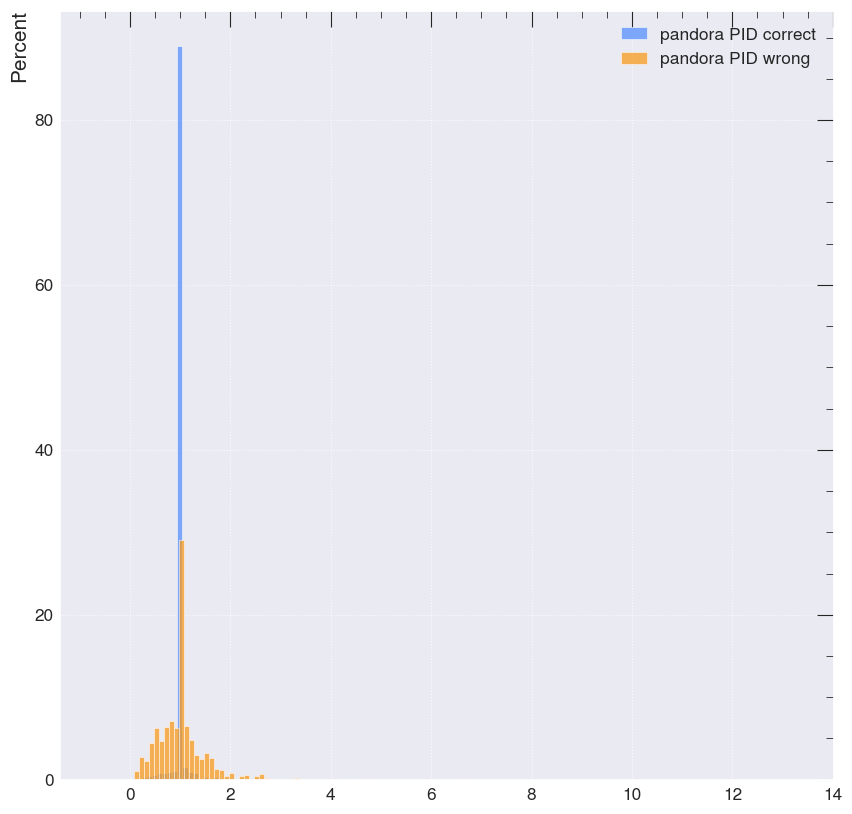

In [25]:
import seaborn as sns
masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo.values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos.values.tolist()), axis=1)**2)
is_pandora_pid_wrong = (masses_pandora < 0.1)
filter = (sd_hgb1.pid == -211) & (is_pandora_pid_wrong == 0)
filter1 = (sd_hgb1.pid == -211) & (is_pandora_pid_wrong == 1)
plt.figure()
#sns.histplot((sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora")
sns.histplot((sd_hgb1[filter].pandora_calibrated_pfo.values)/(sd_hgb1[filter].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora PID correct")
sns.histplot((sd_hgb1[filter1].pandora_calibrated_pfo.values)/(sd_hgb1[filter1].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora PID wrong")
# logscale
#plt.yscale("log")
plt.legend()


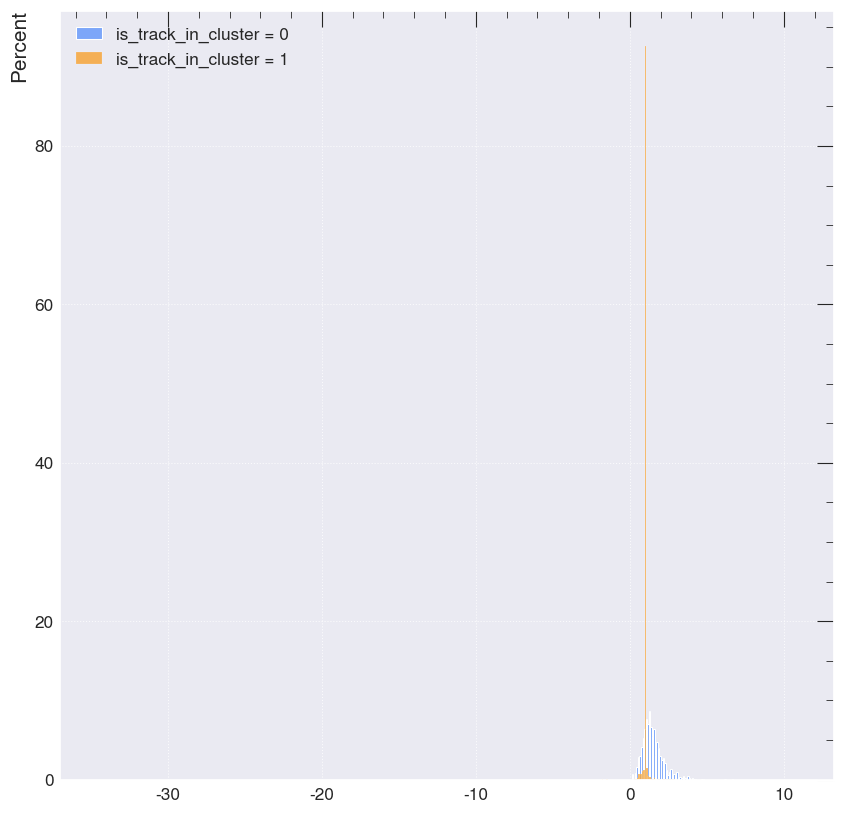

In [26]:
import seaborn as sns
filter = (sd_hgb.pid == 211) & (sd_hgb.is_track_in_cluster == 0)
filter1 = (sd_hgb.pid == 211) & (sd_hgb.is_track_in_cluster == 1)
plt.figure()
#sns.histplot((sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora")
sns.histplot((sd_hgb[filter].calibrated_E.values)/(sd_hgb[filter].true_showers_E.values), stat="percent", binwidth=0.1, label="is_track_in_cluster = 0")
sns.histplot((sd_hgb[filter1].calibrated_E.values)/(sd_hgb[filter1].true_showers_E.values), stat="percent", binwidth=0.1, label="is_track_in_cluster = 1")
# logscale
#plt.yscale("log")
plt.legend()


In [29]:
df=sd_hgb
pandora = False
from torch_scatter import scatter_sum, scatter_mean
true_e = torch.Tensor(df.true_showers_E.values)
mask_nan_true = np.isnan(df.true_showers_E.values)
true_e[mask_nan_true] = 0
batch_idx = df.number_batch

pred_E = df.calibrated_E.values
nan_mask = np.isnan(df.calibrated_E.values)
print(np.sum(nan_mask))
pred_E[nan_mask] = 0
pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
pred_vect = torch.tensor(
    np.array(df.pred_pos_matched.values.tolist()) 
)
pred_vect[nan_mask] = 0
true_vect = torch.tensor(
    np.array(df.true_pos.values.tolist())
)

true_vect[mask_nan_true] = 0
num_tracks_in_cluster = df.is_track_in_cluster.values
num_tracks_in_cluster[mask_nan_true] = 0

batch_idx = torch.tensor(batch_idx.values).long()
pred_E = torch.tensor(pred_E)
true_jet_vect = scatter_sum(true_vect, batch_idx, dim=0)
pred_jet_vect = scatter_sum(pred_vect, batch_idx, dim=0)
true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)
true_jet_p = torch.norm(true_jet_vect, dim=1)  # This is actually momentum resolution
pred_jet_p = torch.norm(pred_jet_vect, dim=1)
mass_true = torch.sqrt(torch.abs(true_E_jet**2) - true_jet_p**2)
mass_pred = torch.sqrt(torch.abs(pred_E_jet**2) - pred_jet_p**2)
mass_over_true = mass_pred / mass_true
E_over_true = pred_E_jet / true_E_jet
p_over_true = pred_jet_p / true_jet_p
E_jet = pred_E_jet
p_jet = pred_jet_p
num_tracks_in_cluster = scatter_sum(torch.tensor(num_tracks_in_cluster), batch_idx)

28824


/tmp/gkrzmanc/ipykernel_43882/2303689504.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
/tmp/gkrzmanc/ipykernel_43882/2303689504.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)


In [30]:
sd_hgb1[sd_hgb1.number_batch==0]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,is_track_in_cluster,true_pos
0,2.970414,5.393750,5.369270,5.369270,3.662885,2.975966,"[-0.11785412579774857, -2.792269706726074, -1....",-211.0,0.0,0.0,1.0,"[-0.11746819317340851, -2.7872824668884277, -1..."
1,4.277524,4.492791,4.744616,3.956491,6.181858,4.281647,"[-0.59894198179245, -3.7868733406066895, -1.90...",211.0,0.0,0.0,1.0,"[-0.6000094413757324, -3.782994508743286, -1.8..."
2,28.105869,27.392633,27.153070,25.920479,27.635689,27.635689,"[-7.799759864807129, -23.8747501373291, -11.52...",22.0,0.0,0.0,0.0,"[-7.938207626342773, -24.27768898010254, -11.7..."
3,1.084628,0.140475,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.03294792398810387, -0.504928469657898, -0...."
4,3.045945,1.936171,2.237006,1.505838,2.025810,2.025810,"[-0.017413277179002762, -1.8372724056243896, -...",2112.0,0.0,0.0,0.0,"[-0.028933800756931305, -2.628115177154541, -1..."
5,0.743262,0.717929,0.693173,0.693173,0.772824,0.772824,"[-0.5338900089263916, -0.490188330411911, -0.2...",-11.0,0.0,0.0,0.0,"[0.08557306975126266, -1.5846405029296875, -0...."
6,27.329964,29.276747,27.859606,27.447966,31.187981,31.187981,"[-8.326078414916992, -28.882814407348633, -8.3...",130.0,0.0,0.0,0.0,"[-7.374933242797852, -25.424392700195312, -6.7..."
7,3.955817,3.639190,3.599153,3.497415,5.418400,5.418400,"[0.14404714107513428, -5.274272918701172, -1.2...",130.0,0.0,0.0,0.0,"[-0.33735010027885437, -3.7916688919067383, -0..."
8,2.274192,1.171103,1.167556,1.167556,2.380802,2.380802,"[2.2533704846078838e-16, -2.3030881881713867, ...",2112.0,0.0,0.0,0.0,"[-0.022470125928521156, -1.97993803024292, -0...."
9,26.538845,20.400921,19.813665,18.546341,21.891596,21.891596,"[-5.042210102081299, -18.999998092651367, -9.6...",2212.0,0.0,0.0,0.0,"[-5.627604961395264, -23.17151641845703, -11.6..."


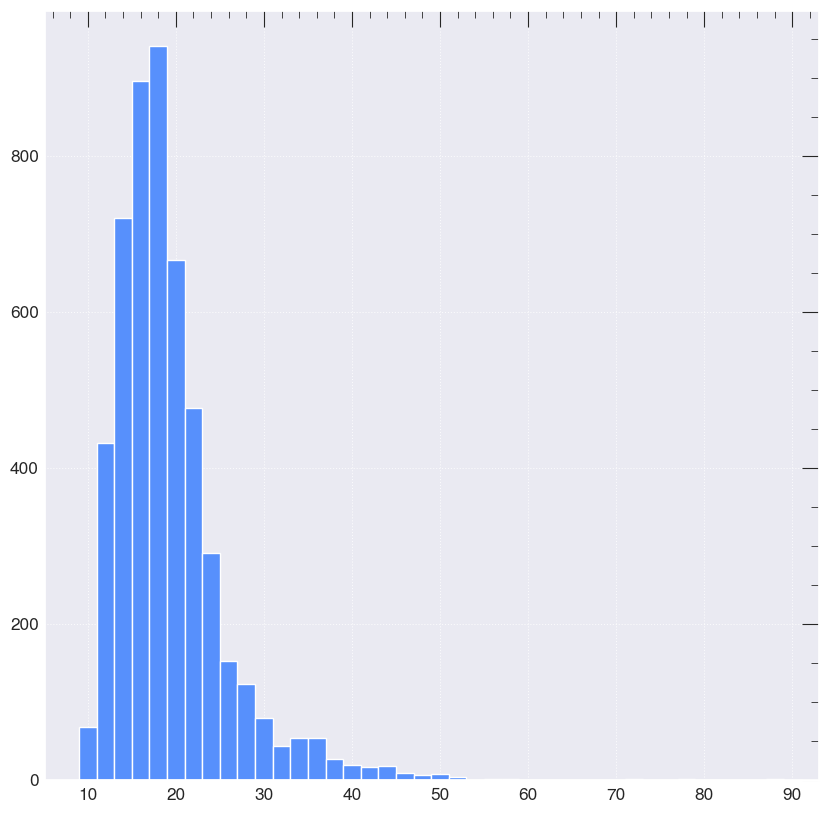

In [31]:
plt.hist(pd.value_counts(sd_hgb1.number_batch.values).values, bins=40)
plt.show()

In [32]:
df=sd_hgb1
pandora = True
from torch_scatter import scatter_sum, scatter_mean
true_e = torch.Tensor(df.true_showers_E.values)
mask_nan_true = np.isnan(df.true_showers_E.values)
true_e[mask_nan_true] = 0
batch_idx = df.number_batch
if pandora:
    pred_E = df.pandora_calibrated_pfo.values
    nan_mask = np.isnan(df.pandora_calibrated_pfo.values)
    pred_E[nan_mask] = 0
    pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
    pred_vect = torch.tensor(np.array(df.pandora_calibrated_pos.values.tolist()))
    nan_mask_p = torch.isnan(pred_vect).any(dim=1)
    pred_vect[nan_mask_p] = 0
    true_vect = torch.tensor(np.array(df.true_pos.values.tolist()))
    mask_nan_p = torch.isnan(true_vect).any(dim=1)
    true_vect[mask_nan_true] = 0
else:
    pred_E = df.calibrated_E.values
    nan_mask = np.isnan(df.calibrated_E.values)
    print(np.sum(nan_mask))
    pred_E[nan_mask] = 0
    pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
    pred_vect = torch.tensor(
        np.array(df.pred_pos_matched.values.tolist()) 
    )
    pred_vect[nan_mask] = 0
    true_vect = torch.tensor(
        np.array(df.true_pos.values.tolist())
    )
    true_vect[mask_nan_true] = 0

batch_idx = torch.tensor(batch_idx.values).long()
pred_E = torch.tensor(pred_E)

true_jet_vect = scatter_sum(true_vect, batch_idx, dim=0)
pred_jet_vect = scatter_sum(pred_vect, batch_idx, dim=0)
true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)
true_jet_p = torch.norm(true_jet_vect, dim=1)  # This is actually momentum resolution
pred_jet_p = torch.norm(pred_jet_vect, dim=1)

mass_true = torch.sqrt(torch.abs(true_E_jet**2)- true_jet_p**2)
mass_pred_p = torch.sqrt(torch.abs(pred_E_jet**2)- pred_jet_p**2) ## TODO: fix the nan values in pred_jet_p!!!!!
# replace nans in these with 0

mass_over_true_p = mass_pred_p / mass_true
E_over_true_pandora = pred_E_jet / true_E_jet
p_over_true_pandora = pred_jet_p / true_jet_p
E_jet_pandora = pred_E_jet
p_jet_pandora = pred_jet_p

/tmp/gkrzmanc/ipykernel_43882/3784951100.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
/tmp/gkrzmanc/ipykernel_43882/3784951100.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)


In [39]:
true_E_jet

tensor([136.8862, 142.5225, 128.6057,  ..., 130.7055, 149.7901, 109.0900])

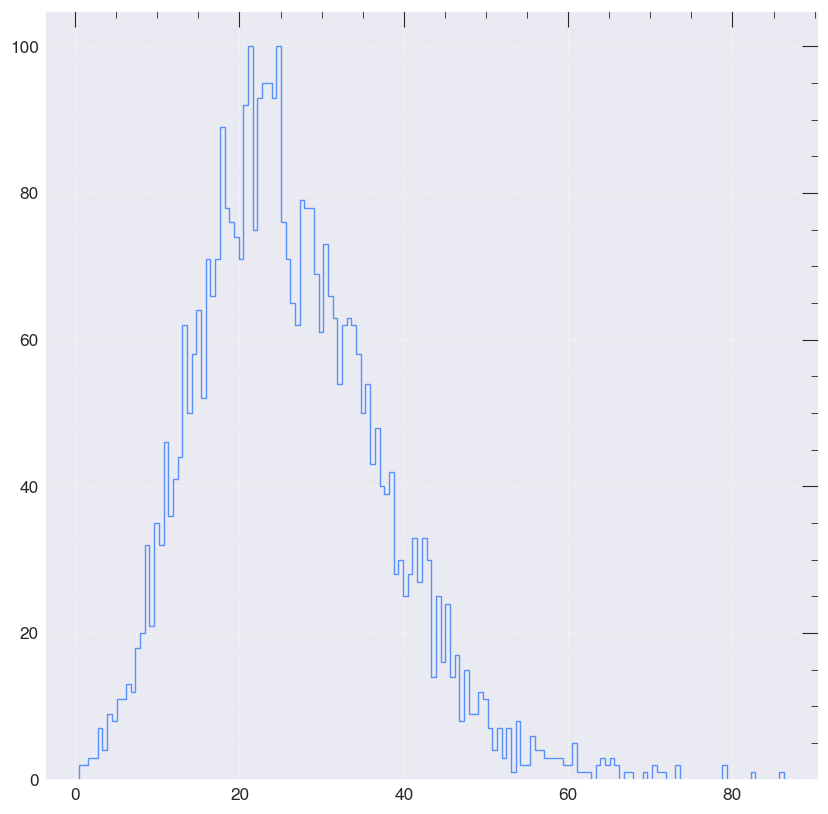

In [34]:
#mass_true histogram
fig, ax = plt.subplots()
ax.hist(mass_true, bins=150, histtype="step")
fig.show()

In [35]:
mass_over_true_p.mean()

tensor(nan, dtype=torch.float64)

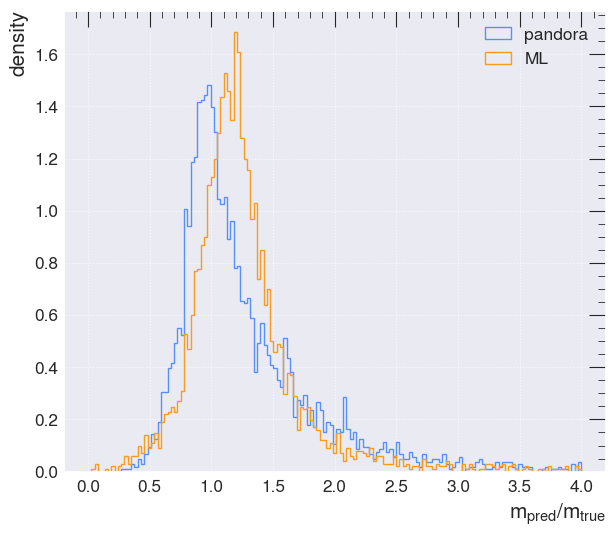

In [42]:
fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0.0, 4.0, 150)
ax.hist(mass_over_true_p, bins=bins, histtype="step", label="pandora", density=True)
ax.hist(mass_over_true, bins=bins, histtype="step", label="ML", density=True)
ax.legend()
ax.grid(True)
#ax.set_yscale("log")
ax.set_xlabel(r"$m_{pred} / m_{true}$")
ax.set_ylabel("density")
fig.show()
fig.savefig("/eos/user/g/gkrzmanc/2024/eval_1015/debug_eval_FT_Ep_reg_1015/mass_peak.pdf")


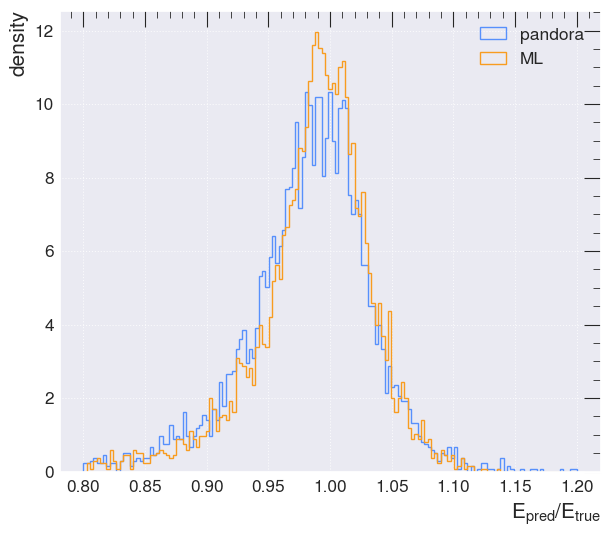

In [35]:
fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0.8, 1.2, 150)
ax.hist(E_over_true_pandora, bins=bins, histtype="step", label="pandora", density=True)
ax.hist(E_over_true, bins=bins, histtype="step", label="ML", density=True)
ax.legend()
ax.grid(True)
#ax.set_yscale("log")
ax.set_xlabel(r"$E_{pred} / E_{true}$")
ax.set_ylabel("density")
fig.show()

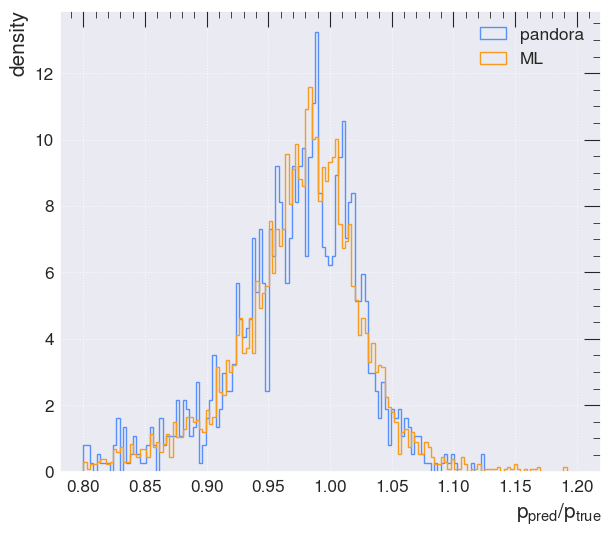

In [36]:
fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0.8, 1.2, 150)
ax.hist(p_over_true_pandora, bins=bins, histtype="step", label="pandora", density=True)
ax.hist(p_over_true, bins=bins, histtype="step", label="ML", density=True)
ax.legend()
ax.grid(True)
#ax.set_yscale("log")
ax.set_xlabel(r"$p_{pred} / p_{true}$")
ax.set_ylabel("density")
fig.show()

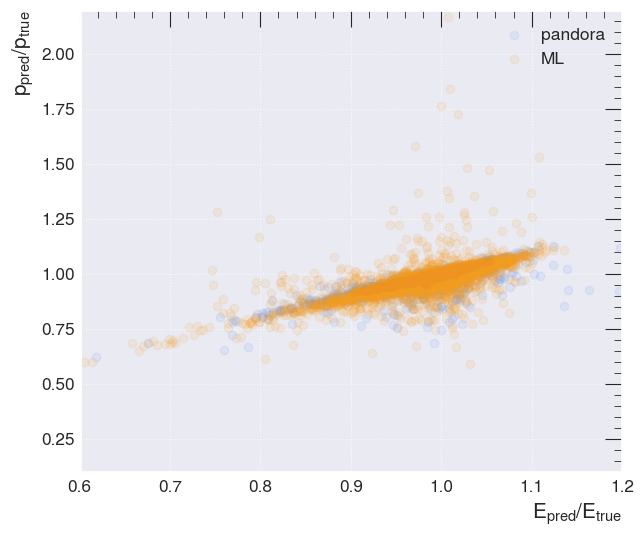

In [37]:
# scatterplot of p_over_true_pandora vs E_over_true_pandora
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(E_over_true_pandora, p_over_true_pandora, label="pandora", alpha=0.1)
ax.scatter(E_over_true, p_over_true, label="ML", alpha=0.1)
ax.legend()
ax.grid(True)
ax.set_xlabel(r"$E_{pred} / E_{true}$")
ax.set_ylabel(r"$p_{pred} / p_{true}$")
ax.set_xlim([0.6, 1.2])
ax.set_ylim([0.1, 2.2])
fig.show()


In [38]:
E_jet_pandora

tensor([129.8072, 141.8524, 111.6109,  ..., 134.0133, 153.2848, 110.0533])

In [299]:
E_jet

tensor([133.2023, 138.9153, 122.0235,  ..., 129.4333, 146.8848, 107.9804])

In [300]:
true_E_jet

tensor([136.8862, 142.5225, 128.6057,  ..., 130.7055, 149.7901, 109.0900])

In [301]:
p_jet

tensor([130.2509, 134.2510, 117.5137,  ..., 127.0936, 153.2716, 104.2375],
       dtype=torch.float64)

In [39]:
p_jet_pandora

tensor([     nan,      nan,      nan,  ..., 132.2838,      nan, 108.2276],
       dtype=torch.float64)

In [40]:
sd_hgb

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,pred_pos_matched,true_pos
0,2.970414,5.393750,5.393750,5.393750,-211.0,0.559277,3.016601,0.0,0.0,1.0,"[-0.11785435676574707, -2.7922751903533936, -1...","[-0.11746819317340851, -2.7872824668884277, -1..."
1,4.277524,4.492791,4.679851,4.097357,211.0,0.909377,4.255750,0.0,0.0,1.0,"[-0.598943293094635, -3.786881923675537, -1.90...","[-0.6000094413757324, -3.782994508743286, -1.8..."
2,28.105869,27.392630,25.866880,24.726151,22.0,1.033783,26.740740,0.0,0.0,0.0,"[-8.229601860046387, -23.17681121826172, -11.0...","[-7.938207626342773, -24.27768898010254, -11.7..."
3,1.084628,0.140475,NaN,NaN,2112.0,NaN,0.000000,0.0,0.0,0.0,"[nan, nan, nan]","[-0.03294792398810387, -0.504928469657898, -0...."
4,3.045945,1.936171,2.414352,1.529647,2112.0,1.047113,2.528099,0.0,0.0,0.0,"[-0.07872776687145233, -2.066555976867676, -0....","[-0.028933800756931305, -2.628115177154541, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
10,33.207466,33.766205,33.732452,33.732456,22.0,1.003800,33.860641,637.0,5099.0,0.0,"[-18.932458877563477, 27.549373626708984, -4.1...","[-17.832475662231445, 27.72899055480957, -3.98..."
11,4.204098,5.512888,4.288906,4.259073,2112.0,0.482528,2.069516,637.0,5099.0,0.0,"[-0.8795002102851868, 1.3807998895645142, 0.32...","[-2.2595677375793457, 3.3564414978027344, 0.64..."
12,0.209143,0.295414,0.311727,0.295414,22.0,0.975628,0.304130,637.0,5099.0,0.0,"[-0.14220444858074188, 0.24032819271087646, 0....","[-0.10423474758863449, 0.17641057074069977, 0...."
13,0.000000,NaN,0.944643,NaN,NaN,NaN,0.000000,637.0,5099.0,0.0,"[nan, nan, nan]","[nan, nan, nan]"
